# Introduction
**This notebook aims at demonstrating how to leverage workflow provenance (information on data processing chains) with a knowledge graph to produce human and machine -oriented data summaries.** We propose to leverage domain-specific annotation ([EDAM ontology](http://edamontology.org/)) from the bioinformatics tools registry [Bio.Tools](http://bio.tools) to automatically annotate workflow processed data in the form of data summaries. 

### Contacts
  - Alban Gaignard: alban.gaignard@univ-nantes.fr
  - Hala Skaf-Molli: hala.skaf@univ-nantes.fr
  - Khalid Belhajjame: kbelhajj@googlemail.com

### Approach
![alt text](approach.png "Approach")
Here are the main steps of this demonstration : 
  1. Knowledge graph loading (With assume that a provenance is already available)
  1. Machine-oriented provenance mining queries
  1. Human-oriented provenance mining queries
  
### Software dependencies 
  - [RdfLib](https://rdflib.readthedocs.io/en/stable/) for RDF data management and SPARQL querying
  - [NetworkX](https://networkx.github.io/documentation/stable/) for graph visualization

In [2]:
from IPython.display import display, Markdown, Latex
from string import Template
import datetime
#import requests
import json
import io

import networkx as nx
from nxpd import draw

from rdflib import ConjunctiveGraph, RDF, RDFS, Namespace

def serialize():
    print(g.serialize(format='turtle'))

def save(filename):
    with open(filename, 'w') as f:
        g.serialize(f, format='turtle')
        
def load(filename):
    with io.open(filename,'r',encoding='utf8') as f:
        g.load(f, format='turtle')  

g = ConjunctiveGraph()
g.bind('prov', Namespace('http://www.w3.org/ns/prov#'))
g.bind('p-plan', Namespace('http://purl.org/net/p-plan#'))
g.bind('biotools', Namespace('https://bio.tools/ontology/'))
g.bind('mp', Namespace('http://purl.org/mp/'))
g.bind('oboInOwl', Namespace('http://www.geneontology.org/formats/oboInOwl#'))

# 1. Caracteristics of the captured provenance graph

### Size of the provenance graph

In [3]:
prov_graph = ConjunctiveGraph()
prov_graph.bind('prov',Namespace('http://www.w3.org/ns/prov#'))
with io.open('provenance.ttl','r',encoding='utf8') as f:
    prov_graph.load(f, format='turtle')
print(str(len(prov_graph)) + " triples in the provenance graph")

555 triples in the provenance graph


### Distribution of PROV classes 

In [4]:
q_classes = "SELECT  ?class (COUNT(?s) AS ?count ) { ?s a ?class } GROUP BY ?class ORDER BY DESC(?count)"
results = prov_graph.query(q_classes)
md = """
| Class name | Number of instances |
|------|------|
""" 
for r in results :
    md = md + "|" + str(r['class']) + " | " + str(r['count']) + " | " + "\n"
display(Markdown(md))


| Class name | Number of instances |
|------|------|
|http://www.w3.org/ns/prov#Entity | 40 | 
|http://www.w3.org/ns/prov#Activity | 26 | 
|http://www.w3.org/ns/prov#Person | 1 | 
|http://www.w3.org/ns/prov#Agent | 1 | 
|http://www.w3.org/ns/prov#Bundle | 1 | 


### Distribution of PROV predicates

In [5]:
q_properties  = " SELECT  ?p (COUNT(?s) AS ?count ) { ?s ?p ?o } GROUP BY ?p ORDER BY DESC(?count)"
results = prov_graph.query(q_properties)
md = """
| Property name | Number of predicates |
|------|------|
""" 
for r in results :
    md = md + "|" + str(r['p']) + " | " + str(r['count']) + " | " + "\n"
display(Markdown(md))


| Property name | Number of predicates |
|------|------|
|http://www.w3.org/ns/prov#wasDerivedFrom | 167 | 
|http://www.w3.org/ns/prov#used | 100 | 
|http://www.w3.org/1999/02/22-rdf-syntax-ns#type | 69 | 
|http://www.w3.org/ns/prov#wasAssociatedWith | 65 | 
|http://www.w3.org/ns/prov#wasGeneratedBy | 39 | 
|http://www.w3.org/2000/01/rdf-schema#label | 39 | 
|http://www.w3.org/ns/prov#startedAtTime | 26 | 
|http://www.w3.org/ns/prov#endedAtTime | 26 | 
|http://www.w3.org/2000/01/rdf-schema#comment | 22 | 
|http://www.w3.org/ns/prov#generatedAtTime | 1 | 
|http://www.w3.org/ns/prov#wasAttributedTo | 1 | 


# 1. Loading the Knowledge Graph
This graph is built from: 
   - the workflow run as a provenance graph (PROV-O): `provenance.ttl`
   - a dump of the [bio.tools](http://bio.tools) registry: `biotools-dump-latest.ttl`
   - the [EDAM](http://edamontology.org) ontology: `EDAM.owl`

Data loading takes around 20s. 

In [6]:
%%time
experiment = """
@prefix mp:  <http://purl.org/mp/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

_:mp1 rdf:type mp:Micropublication ;
    mp:argues _:claim1 .

_:claim1 rdf:type mp:Claim ;
    mp:statement "Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm" .
"""
g.parse(data=experiment, format='turtle')

load('provenance.ttl')
print('provenance.ttl loaded')

load('biotools-dump-latest.ttl')
print('biotools-dump-latest.ttl loaded')

with io.open('EDAM.owl','r',encoding='utf8') as f:
        g.load(f, format='xml')
print('edam.owl loaded')

print()
print('Graph size: %s triples' % len(g))

provenance.ttl loaded
biotools-dump-latest.ttl loaded
edam.owl loaded

Graph size: 203171 triples
CPU times: user 12.7 s, sys: 109 ms, total: 12.8 s
Wall time: 12.8 s


# 2. Human-oriented data summaries

## Sentence-based data explanations  
Here, the goal is to describe a piece of data with the consensual definition of **what** does the tool that generates this piece of data.  
Technically, this is done with a SPARQL query that combine the provenance information (*prov:wasGeneratedBy*), the description of the tool (*biotools:has_function*), and the domain knowledge on the nature of the processing (*oboInOwl:hasDefinition*). 

In [7]:
%%time
query = """
    SELECT ?d_label ?title ?f_def ?st WHERE {
        ?d rdf:type prov:Entity ;
           prov:wasGeneratedBy ?x ;
           prov:wasAssociatedWith ?tool ;
           rdfs:label ?d_label .
        
        ?tool dc:title ?title ;
            biotools:has_function ?f .
            
        ?f rdfs:label ?f_label ;
            oboInOwl:hasDefinition ?f_def .
            
        ?c rdf:type mp:Claim ;    
            mp:statement ?st .
    }
"""

results = g.query(query)
for r in results :
    display(Markdown('The file `' + str(r['d_label']) + '`'
                     +' **results from tool** ' + str(r['title']) 
                     + ' **which** ' + str(r['f_def'])))
    display(Markdown(' **It was produced in the context of** ' + str(r['st']) ))


The file `Samples/Sample1/BAM/Sample1.realign.bai` **results from tool** gatk2_indel_realigner-IP **which** Locally align two or more molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.combined.g.vcf.gz.tbi` **results from tool** gatk2_variant_combine-IP **which** Merge two or more (typically overlapping) molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.recal.table` **results from tool** gatk2_base_recalibrator-IP **which** Analyse one or more known molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.indel.recal.select.vcf.gz.tbi` **results from tool** gatk2_variant_select-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.recal.combined.vcf.gz.tbi` **results from tool** gatk2_variant_combine-IP **which** Merge two or more (typically overlapping) molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.recal.combined.vcf.gz` **results from tool** gatk2_variant_combine-IP **which** Merge two or more (typically overlapping) molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.realign.intervals` **results from tool** gatk2_realigner_target_creator-IP **which** Locally align two or more molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.snv.recal.select.vcf.gz.tbi` **results from tool** gatk2_variant_select-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.markdup.bam` **results from tool** MarkDuplicates (IP) **which** Predict, recognise and identify positional features in molecular sequences such as key functional sites or regions.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.p1.aligned.sam` **results from tool** BWA (cloudIFB) **which** Construct some data entity.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.p1.aligned.sam` **results from tool** BWA (cloudIFB) **which** Generate an index of a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.p1.aligned.sam` **results from tool** BWA (cloudIFB) **which** Align short oligonucleotide sequences (reads) to a larger (genomic) sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.p1.aligned.sam` **results from tool** BWA (cloudIFB) **which** Align (identify equivalent sites within) molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.recal.combined.annot.gnomad.vcf.gz` **results from tool** gatk2_variant_annotator-IP **which** Predict the effect or function of an individual single nucleotide polymorphism (SNP).

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.p1.sorted.bam` **results from tool** samtools_sort-IP **which** Reformat a file of data (or equivalent entity in memory).

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.combined.g.vcf.gz` **results from tool** gatk2_variant_combine-IP **which** Merge two or more (typically overlapping) molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.snv.recal.filter.vcf.gz.tbi` **results from tool** gatk2_variant_filtration-IP **which** Analyse a genetic variation, for example to annotate its location, alleles, classification, and effects on individual transcripts predicted for a gene model.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.snv.recal.filter.vcf.gz.tbi` **results from tool** gatk2_variant_filtration-IP **which** Filter a set of files or data items according to some property.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `BED/capture.extended1000.bed` **results from tool** bedtools_mergebedgraph-IP **which** Merge two or more (typically overlapping) molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.recal.combined.annot.gnomad.vcf.gz.tbi` **results from tool** gatk2_variant_annotator-IP **which** Predict the effect or function of an individual single nucleotide polymorphism (SNP).

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.genotyped.vcf.gz` **results from tool** gatk2_unified_genotyper-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.genotyped.vcf.gz` **results from tool** gatk2_unified_genotyper-IP **which** Identify insertion, deletion and duplication events from a sequence alignment.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.indel.recal.select.vcf.gz` **results from tool** gatk2_variant_select-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `BED/capture.bed` **results from tool** bedtools_mergebedgraph-IP **which** Merge two or more (typically overlapping) molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.snv.recal.select.vcf.gz` **results from tool** gatk2_variant_select-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.snv.recal.filter.vcf.gz` **results from tool** gatk2_variant_filtration-IP **which** Analyse a genetic variation, for example to annotate its location, alleles, classification, and effects on individual transcripts predicted for a gene model.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.snv.recal.filter.vcf.gz` **results from tool** gatk2_variant_filtration-IP **which** Filter a set of files or data items according to some property.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.realign.bam` **results from tool** gatk2_indel_realigner-IP **which** Locally align two or more molecular sequences.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.genotyped.vcf.gz.tbi` **results from tool** gatk2_unified_genotyper-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.genotyped.vcf.gz.tbi` **results from tool** gatk2_unified_genotyper-IP **which** Identify insertion, deletion and duplication events from a sequence alignment.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.merged.bam` **results from tool** Picard **which** Analyse a genetic variation, for example to annotate its location, alleles, classification, and effects on individual transcripts predicted for a gene model.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.final.bai` **results from tool** gatk2_print_reads-IP **which** Counting and summarising the number of short sequence reads that map to genomic features.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/VCF/Sample1.hapcaller.g.vcf` **results from tool** gatk2_haplotype_caller-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.indel.recal.filter.vcf.gz` **results from tool** gatk2_variant_filtration-IP **which** Analyse a genetic variation, for example to annotate its location, alleles, classification, and effects on individual transcripts predicted for a gene model.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.indel.recal.filter.vcf.gz` **results from tool** gatk2_variant_filtration-IP **which** Filter a set of files or data items according to some property.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/QC/Sample1.markdup.metrics` **results from tool** MarkDuplicates (IP) **which** Predict, recognise and identify positional features in molecular sequences such as key functional sites or regions.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.final.bam` **results from tool** gatk2_print_reads-IP **which** Counting and summarising the number of short sequence reads that map to genomic features.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.merged.bai` **results from tool** Picard **which** Analyse a genetic variation, for example to annotate its location, alleles, classification, and effects on individual transcripts predicted for a gene model.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.indel.recal.filter.vcf.gz.tbi` **results from tool** gatk2_variant_filtration-IP **which** Analyse a genetic variation, for example to annotate its location, alleles, classification, and effects on individual transcripts predicted for a gene model.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `VCF/hapcaller.indel.recal.filter.vcf.gz.tbi` **results from tool** gatk2_variant_filtration-IP **which** Filter a set of files or data items according to some property.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/VCF/Sample1.hapcaller.g.vcf.idx` **results from tool** gatk2_haplotype_caller-IP **which** Identify and map genomic alterations, including single nucleotide polymorphisms, short indels and structural variants, in a genome sequence.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

The file `Samples/Sample1/BAM/Sample1.markdup.bai` **results from tool** MarkDuplicates (IP) **which** Predict, recognise and identify positional features in molecular sequences such as key functional sites or regions.

 **It was produced in the context of** Rare Coding Variants in ANGPTL6 Are Associated with Familial Forms of Intracranial Aneurysm

CPU times: user 121 ms, sys: 21 ms, total: 142 ms
Wall time: 139 ms


## Summary graph of  the main processing steps
### Here, the goal is to display a graph of domain-specific terms, describing the workflow processing steps. 

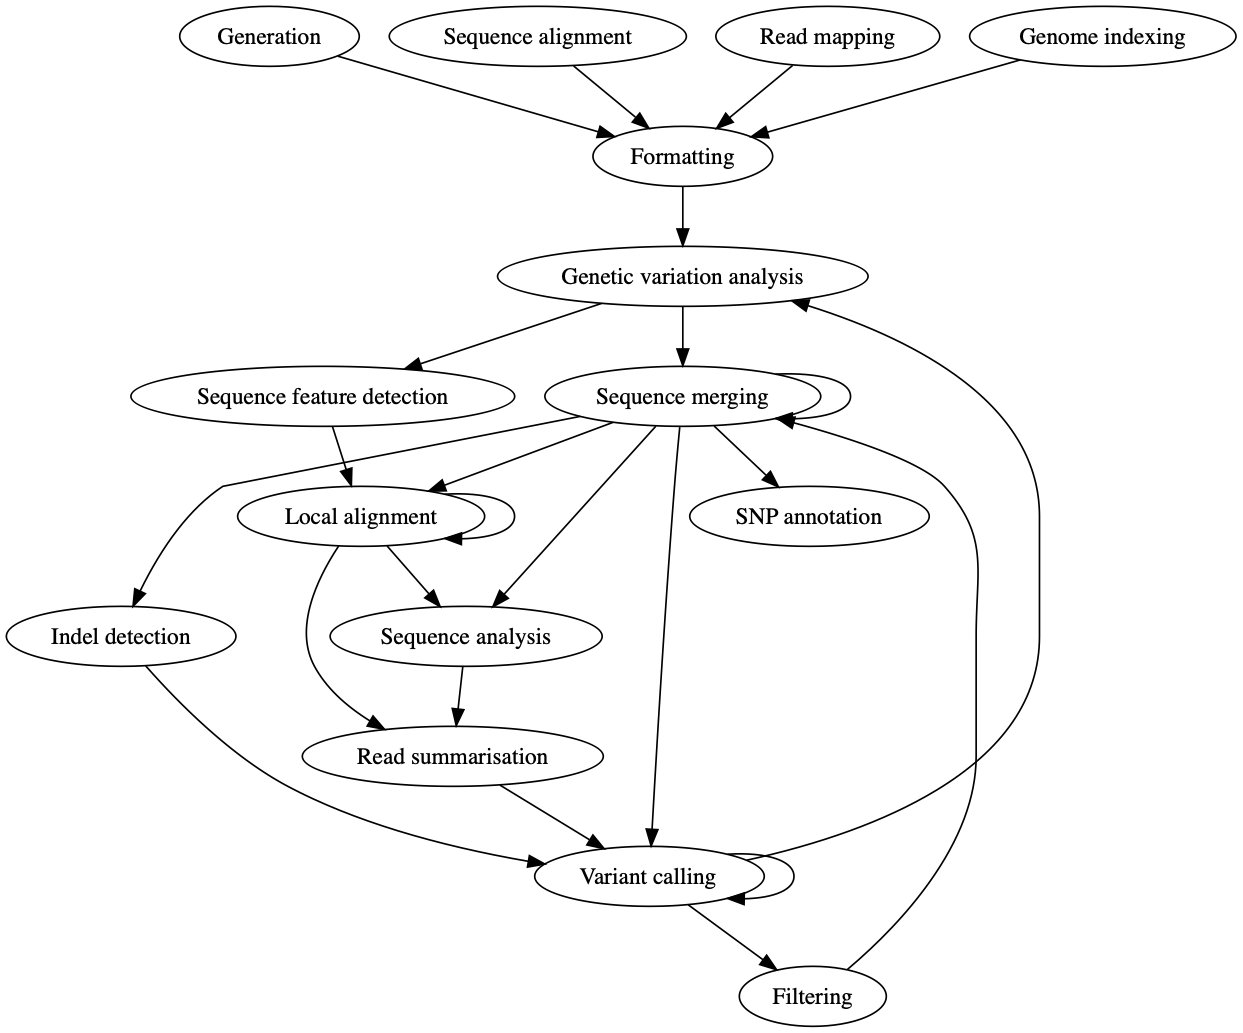

In [10]:
edges = []

query = """
    CONSTRUCT {
        ?x2 p-plan:wasPreceededBy ?x1 .
        ?x2 prov:wasAssociatedWith ?t2 .
        ?x1 prov:wasAssociatedWith ?t1 .
        ?t1 biotools:has_function ?f1 .
        ?f1 rdfs:label ?f1_label .
        ?t2 biotools:has_function ?f2 .
        ?f2 rdfs:label ?f2_label .
    } WHERE {
        ?d2 prov:wasDerivedFrom ?d1 .
        
        ?d2 prov:wasGeneratedBy ?x2 ;
           prov:wasAssociatedWith ?t2 ;
           rdfs:label ?d2_label .
        
        ?d1 prov:wasGeneratedBy ?x1 ;
           prov:wasAssociatedWith ?t1 ;
           rdfs:label ?d1_label .
        
        ?t1 biotools:has_function ?f1 .
        ?f1 rdfs:label ?f1_label .
        
        ?t2 biotools:has_function ?f2 .
        ?f2 rdfs:label ?f2_label .
    }
"""

abstract_wf = ConjunctiveGraph()
abstract_wf.bind('prov',Namespace('http://www.w3.org/ns/prov#'))
abstract_wf.bind('p-plan',Namespace('http://purl.org/net/p-plan#'))
abstract_wf.bind('biotools',Namespace('https://bio.tools/ontology/'))

results = g.query(query)
for r in results :
    abstract_wf.add(r)

abstract_wf.serialize(destination='abstract_wf.ttl', format='turtle')

vis_query = """
    SELECT ?f1_label ?f2_label WHERE {
        ?x2 p-plan:wasPreceededBy ?x1 .
        ?x2 prov:wasAssociatedWith ?t2 .
        ?x1 prov:wasAssociatedWith ?t1 .
        ?t1 biotools:has_function ?f1 .
        ?f1 rdfs:label ?f1_label .
        ?t2 biotools:has_function ?f2 .
        ?f2 rdfs:label ?f2_label .
    }
"""

results = abstract_wf.query(vis_query)
for r in results :
    edges.append((r['f1_label'], r['f2_label']))

G = nx.DiGraph()
G.graph['dpi'] = 120
G.graph['layout'] = 'dot'
G.add_edges_from(edges)

#pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
#nx.draw(G, pos)
draw(G, show='ipynb')

### Finally we show in this last cell how we can document intermediate data with the conceptual processing they result from, again with domain-specific terms. 

In [11]:
%%time
pattern_intermediate = "Sample1.final.bam"
pattern_final = "hapcaller.recal.combined.annot.gnomad.vcf.gz"

query = """
    CONSTRUCT {
        ?x2 p-plan:wasPreceededBy ?x1 .
        ?x2 prov:wasAssociatedWith ?t2 .
        ?x1 prov:wasAssociatedWith ?t1 .
        ?t1 biotools:has_function ?f1 .
        ?f1 rdfs:label ?f1_label .
        ?t2 biotools:has_function ?f2 .
        ?f2 rdfs:label ?f2_label .
        
        ?d rdf:type prov:Entity ;
               prov:wasGeneratedBy ?x ;
               prov:wasAssociatedWith ?tool ;
               rdfs:label ?d_label .
    } WHERE {
        {
            ?d2 prov:wasDerivedFrom ?d1 .
        
            ?d2 prov:wasGeneratedBy ?x2 ;
               prov:wasAssociatedWith ?t2 ;
               rdfs:label ?d2_label .
        
            ?d1 prov:wasGeneratedBy ?x1 ;
               prov:wasAssociatedWith ?t1 ;
               rdfs:label ?d1_label .
        
            ?t1 biotools:has_function ?f1 .
            ?f1 rdfs:label ?f1_label .
        
            ?t2 biotools:has_function ?f2 .
            ?f2 rdfs:label ?f2_label .
        } UNION {
            ?d rdf:type prov:Entity ;
               prov:wasGeneratedBy ?x ;
               prov:wasAssociatedWith ?tool ;
               rdfs:label ?d_label .
            FILTER (regex(?d_label, \"""" + pattern_intermediate + """\", "i")) .
        }
    }
"""

abstract_wf = ConjunctiveGraph()
abstract_wf.bind('prov',Namespace('http://www.w3.org/ns/prov#'))
abstract_wf.bind('p-plan',Namespace('http://purl.org/net/p-plan#'))
abstract_wf.bind('biotools',Namespace('https://bio.tools/ontology/'))

results = g.query(query)
for r in results :
    abstract_wf.add(r)

abstract_wf.serialize(destination='abstract_wf.ttl', format='turtle')

vis_query1 = """
    SELECT ?f1_label ?f2_label WHERE {
        ?x2 p-plan:wasPreceededBy ?x1 .
        ?x2 prov:wasAssociatedWith ?t2 .
        ?x1 prov:wasAssociatedWith ?t1 .
        ?t1 biotools:has_function ?f1 .
        ?f1 rdfs:label ?f1_label .
        ?t2 biotools:has_function ?f2 .
        ?f2 rdfs:label ?f2_label .
    }
"""

edges = []
results = abstract_wf.query(vis_query1)
for r in results :
    edges.append((r['f1_label'], r['f2_label']))

vis_query2 = """
    SELECT ?d_label ?tool ?f_label WHERE {
        ?d rdf:type prov:Entity ;
            prov:wasGeneratedBy ?x ;
            prov:wasAssociatedWith ?tool ;
            rdfs:label ?d_label .
        ?tool biotools:has_function ?f .
        ?f rdfs:label ?f_label .
    }
"""

edges_data = []
nodes_data = []
results = abstract_wf.query(vis_query2)
for r in results :
    edges_data.append((r['f_label'], r['d_label']))
    nodes_data.append(r['d_label'])

G = nx.DiGraph()
G.graph['dpi'] = 120
G.graph['layout'] = 'dot'
G.add_nodes_from(nodes_data, color='blue', shape="note")
G.add_edges_from(edges)
G.add_edges_from(edges_data, color='blue', style="dashed")

CPU times: user 224 ms, sys: 5.58 ms, total: 230 ms
Wall time: 229 ms


CPU times: user 10.8 ms, sys: 6.48 ms, total: 17.2 ms
Wall time: 72.8 ms


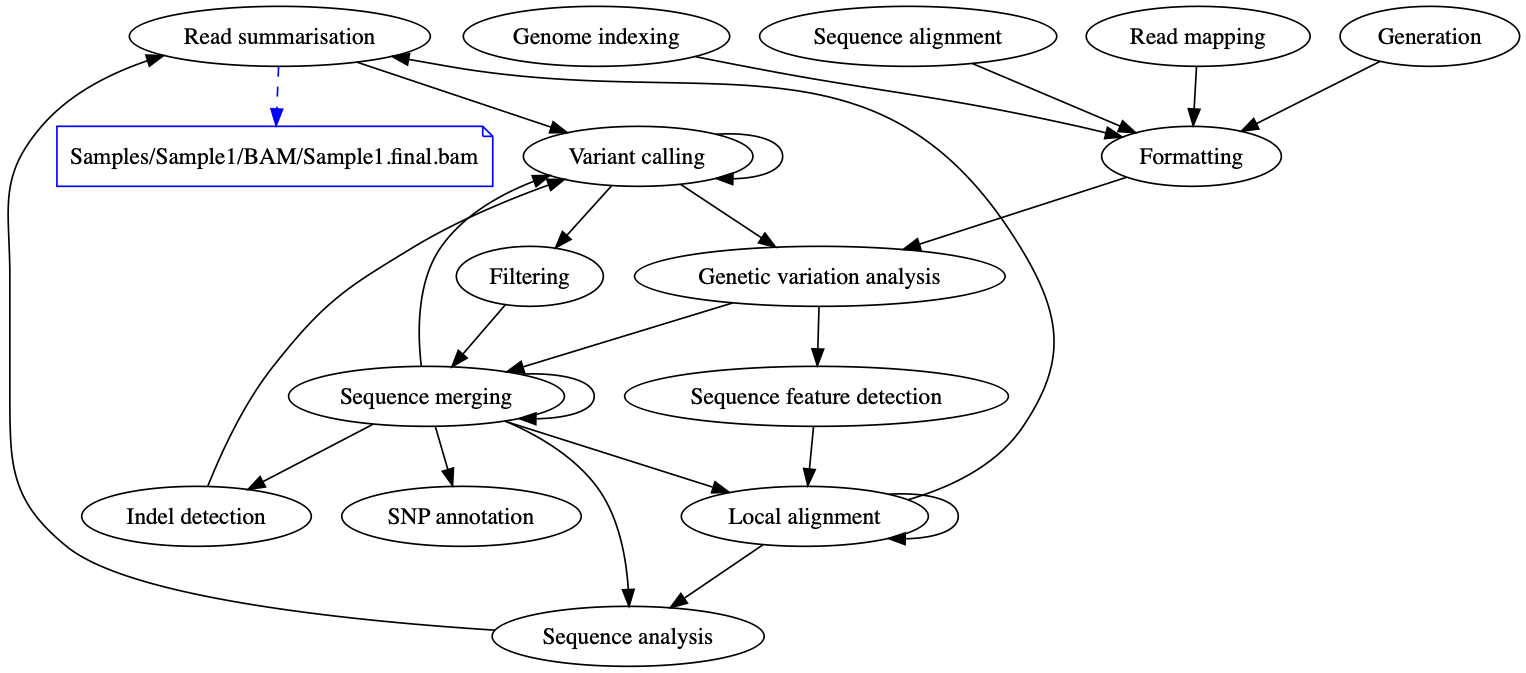

In [12]:
#%time draw(G, filename='plot.pdf', format='pdf')
%time draw(G, show='ipynb')

# 3. Machine-oriented summaries

Here we assemble a [NanoPublication](http://nanopub.org/wordpress/) aimed at reporting, from the provenance, what has been done on data, with domain-specific annotations. The SPARQL CONSTRUCT query produces RDF triples representing the workflow steps ([P-Plan ontology](http://www.opmw.org/model/p-plan/)) and their nature in terms of [EDAM operations](http://edamontology.org). These triples form the *Assertion* named graph of the publication. 

In [16]:
my_ORCID = "0000-0002-3597-8557"

wf_assertions = []

np_wf_query = """
    CONSTRUCT {
        ?x2 p-plan:wasPreceededBy ?x1 .
        ?x2 rdf:type p-plan:Step ;
            biotools:has_function ?f2 ; 
            rdfs:seeAlso ?t2 .
        ?x1 rdf:type p-plan:Step ;
            biotools:has_function ?f1 ; 
            rdfs:seeAlso ?t1 .
    } WHERE {
        ?x2 rdf:type prov:Activity ;
            prov:wasAssociatedWith ?t2 .
        ?x1 rdf:type prov:Activity ;
            prov:wasAssociatedWith ?t1 .
        ?t1 biotools:has_function ?f1 .
        ?f1 rdfs:label ?f1_label .
        ?t2 biotools:has_function ?f2 .
        ?f2 rdfs:label ?f2_label .
    } 
"""

results = g.query(np_wf_query)
for r in results :
    wf_assertions.append('<'+str(r[0])+'>' " " + '<'+str(r[1])+'>' + " " + '<'+str(r[2])+'> .')

nanopub_template = """

@prefix : <http://example.org/pub1#> .
@prefix ex: <http://example.org/> .
@prefix np:  <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> . 
@prefix xsd:  <http://www.w3.org/2001/XMLSchema#> .

:head {
    ex:pub1 a np:Nanopublication .
    ex:pub1 np:hasAssertion :assertion .
    ex:pub1 np:hasProvenance :provenance .
    ex:pub1 np:hasPublicationInfo :pubInfo .
}

:assertion {
    $Assertion
}

:provenance {
    :assertion prov:generatedAtTime \""""+datetime.datetime.now().isoformat()+"""\"^^xsd:dateTime .
    :assertion prov:wasDerivedFrom :experiment .
    :assertion prov:wasAttributedTo <https://orcid.org/"""+my_ORCID+"""> .
}

:pubInfo {
    ex:pub1 prov:wasAttributedTo <https://orcid.org/"""+my_ORCID+"""> .
}

"""

assert_graph = ('\n\t').join(wf_assertions)

np = Template(nanopub_template)
np = np.substitute(Assertion = assert_graph)

print(np)



@prefix : <http://example.org/pub1#> .
@prefix ex: <http://example.org/> .
@prefix np:  <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> . 
@prefix xsd:  <http://www.w3.org/2001/XMLSchema#> .

:head {
    ex:pub1 a np:Nanopublication .
    ex:pub1 np:hasAssertion :assertion .
    ex:pub1 np:hasProvenance :provenance .
    ex:pub1 np:hasPublicationInfo :pubInfo .
}

:assertion {
    <http://snakemake-provenance#activity-6fc46366-474b-4cc6-8e69-fbb54c014881> <http://purl.org/net/p-plan#wasPreceededBy> <http://snakemake-provenance#activity-b4de3b83-1cc6-4f48-ad48-540d300cf703> .
	<http://snakemake-provenance#activity-3b3476df-63c8-47c6-b7df-18a96b8ca4b9> <http://www.w3.org/2000/01/rdf-schema#seeAlso> <https://bio.tools/gatk2_variant_select-ip> .
	<http://snakemake-provenance#activity-6fc46366-474b-4cc6-8e69-fbb54c014881> <http://purl.org/net/p-plan#wasPreceededBy> <http://snakemake-provenance#activity-7a09a3bb-e940-4d70-b242-48ce8fca4dd9> .
	<http://snakema

### Now we focus more on data and associate the domain annotations gathered from the tools to each processed data. 

In [13]:
%%time
my_ORCID = "0000-0002-3597-8557"

data_assertions = []

np_data_query = """
    CONSTRUCT {
        ?d rdfs:seeAlso ?f .
        ?d rdfs:comment ?f_def .
    } WHERE {
        ?d rdf:type prov:Entity ;
           prov:wasGeneratedBy ?x ;
           prov:wasAssociatedWith ?tool ;
           rdfs:label ?d_label .
        
        ?tool dc:title ?title ;
            biotools:has_function ?f .
            
        ?f rdfs:label ?f_label ;
            oboInOwl:hasDefinition ?f_def .
    }
"""

results = g.query(np_data_query)
for r in results :
    data_assertions.append('<'+str(r[0])+'>' " " + '<'+str(r[1])+'>' + " " + '<'+str(r[2])+'> .')


nanopub_template = """

@prefix : <http://example.org/pub1#> .
@prefix ex: <http://example.org/> .
@prefix np:  <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> . 
@prefix xsd:  <http://www.w3.org/2001/XMLSchema#> .

:head {
    ex:pub1 a np:Nanopublication .
    ex:pub1 np:hasAssertion :assertion .
    ex:pub1 np:hasProvenance :provenance .
    ex:pub1 np:hasPublicationInfo :pubInfo .
}

:assertion {
    $Assertion
}

:provenance {
    :assertion prov:generatedAtTime \""""+datetime.datetime.now().isoformat()+"""\"^^xsd:dateTime .
    :assertion prov:wasDerivedFrom :experiment .
    :assertion prov:wasAttributedTo <https://orcid.org/"""+my_ORCID+"""> .
}

:pubInfo {
    ex:pub1 prov:wasAttributedTo <https://orcid.org/"""+my_ORCID+"""> .
}

"""

assert_graph = ('\n\t').join(data_assertions)

np = Template(nanopub_template)
np = np.substitute(Assertion = assert_graph)

print(np)



@prefix : <http://example.org/pub1#> .
@prefix ex: <http://example.org/> .
@prefix np:  <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> . 
@prefix xsd:  <http://www.w3.org/2001/XMLSchema#> .

:head {
    ex:pub1 a np:Nanopublication .
    ex:pub1 np:hasAssertion :assertion .
    ex:pub1 np:hasProvenance :provenance .
    ex:pub1 np:hasPublicationInfo :pubInfo .
}

:assertion {
    <http://snakemake-provenance/Samples/Sample1/BAM/Sample1.p1.aligned.sam> <http://www.w3.org/2000/01/rdf-schema#seeAlso> <http://edamontology.org/operation_0292> .
	<http://snakemake-provenance/Samples/Sample1/BAM/Sample1.merged.bam> <http://www.w3.org/2000/01/rdf-schema#comment> <Analyse a genetic variation, for example to annotate its location, alleles, classification, and effects on individual transcripts predicted for a gene model.> .
	<http://snakemake-provenance/VCF/hapcaller.genotyped.vcf.gz.tbi> <http://www.w3.org/2000/01/rdf-schema#comment> <Identify and map genomic al